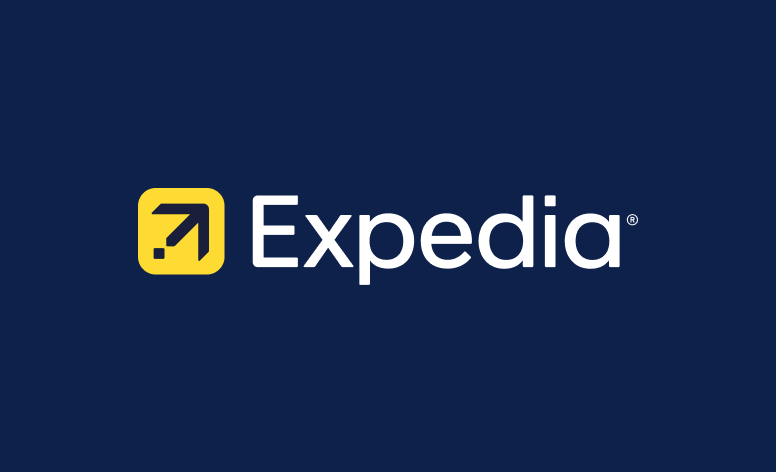)
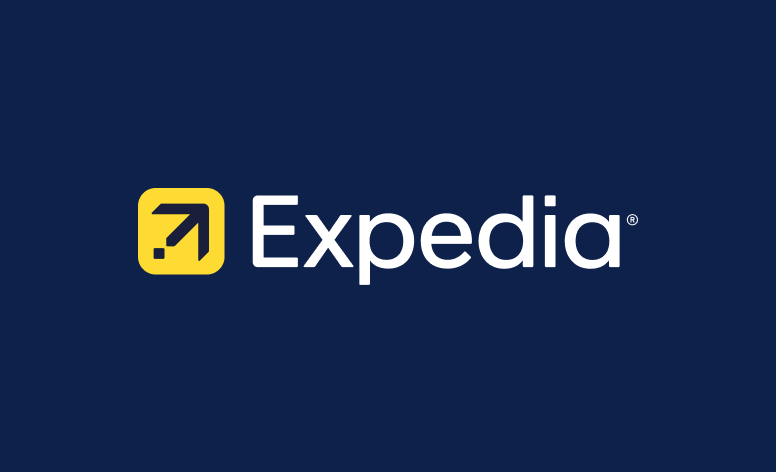

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import pandas as pd
pd.set_option('display.max_columns',None)
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler
from sklearn import preprocessing,cluster
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.metrics import silhouette_samples,silhouette_score,davies_bouldin_score
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso,LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
import statsmodels as sm
from scipy import stats
from time import time
from imblearn.under_sampling import RandomUnderSampler
from warnings import simplefilter
simplefilter("ignore")
from sklearn.ensemble import IsolationForest



In [ ]:

import random
np.random.seed(42)
random.seed(42)

In [ ]:
data = pd.read_csv('/kaggle/input/expedia-travel-dataset/travel.csv')

data.head()

In [ ]:
data.describe()

<h1>Missing values and duplicates</h1>

In [ ]:
print(f'Total number of missing values: {data.isnull().sum().sum()}')


In [ ]:
data_count0 = data.loc[((data.srch_adults_cnt) + (data.srch_children_cnt)) == 0]

data_count0

In [ ]:
data_children_alone = data.loc[data.srch_adults_cnt == 0]

data_children_alone.head(3)

In [ ]:
rows_to_drop = pd.concat([data_count0,data_children_alone]).drop_duplicates()

print(f'Number of rows to drop: {len(rows_to_drop)}') 
print(f'Expected length of the dataframe after dropping these rows: {len(data) - len(rows_to_drop)}')

In [ ]:
data.drop(rows_to_drop.index,inplace=True)

len(data)

##  Date and Datetime Columns¶


In [ ]:

df = pd.DataFrame(data)
df.dropna(subset=['srch_ci', 'srch_co'], inplace=True)
df['srch_ci'] = pd.to_datetime(df['srch_ci'])
df['srch_co'] = pd.to_datetime(df['srch_co'])

In [ ]:
def get_season(date):
    month = date.month
    if month in [11, 12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10]:
        return 'Autumn'
df['season'] = df['srch_ci'].apply(get_season)

In [ ]:
 

df['is_local'] = (df['hotel_country'] == df['user_location_country']).astype(int)


df['is_same_continent'] = (df['posa_continent'] == df['hotel_continent']).astype(int)


market_density = df['hotel_market'].value_counts(normalize=True)
df['market_density'] = df['hotel_market'].map(market_density)
np.random.seed(42)

df['srch_co'] = df['srch_co'].where(df['srch_co'] >= df['srch_ci'], df['srch_ci'] + pd.Timedelta(days=3))
df['duration_of_stay'] = (df['srch_co'] - df['srch_ci']).dt.days
df['duration_of_stay'] = df['duration_of_stay'].abs()
df['season'] = df['srch_ci'].apply(get_season)
srch_destination_type_density = df['srch_destination_type_id'].value_counts(normalize=True)
df['srch_destination_type_density'] = df['srch_destination_type_id'].map(srch_destination_type_density)

In [ ]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='srch_destination_type_id', y='duration_of_stay', data=df, palette='Set2')
plt.title('Distribution of length of stay by destination type')
plt.xlabel('Destination Type')
plt.ylabel('Length of Stay (days)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

General Distribution:

* Most destination types (1, 3, 4, 5, 6, 7, 8, and 9) exhibit narrow, low distributions, with most values ​​ranging between 0 and 50 days.
* Destination types 1 and 3 exhibit very high extreme values ​​(up to approximately 150–200 days), indicating outliers or exceptionally long stays.

Outliers:

* Destination type 1 has a clear outlier at around 150 days, with a slight spread above 100 days.
* Destination type 3 has an outlier of approximately 200 days, indicating very long stays (possibly due to data errors or special circumstances such as long-term stays).
* The other destination types (4, 5, 6, 7, 8, and 9) exhibit less pronounced outliers, with more homogeneous distributions.

In [ ]:
plt.figure(figsize=(12, 5))

# Violin Plot for Number of Adults
plt.subplot(1, 2, 1)
sns.violinplot(x='srch_adults_cnt', y='duration_of_stay', data=df, palette='Blues')
plt.title('Distribution of Length of Stay by Number of Adults')
plt.xlabel('Number of Adults')
plt.ylabel('Duration of Stay (Days)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Violin Plot for Number of Children
plt.subplot(1, 2, 2)
sns.violinplot(x='srch_children_cnt', y='duration_of_stay', data=df, palette='Oranges')
plt.title('Distribution of length of stay by number of children')
plt.xlabel('Number of children')
plt.ylabel('Length of stay (days)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

* The image presents two Violin Plots illustrating the distribution of length of stay (duration_of_stay) based on the number of adults (srch_adults_cnt) and the number of children (srch_children_cnt):

First Plot (Number of Adults):

* Most values range between 0-50 days, with a noticeable outlier around 150-175 days for 1 and 4 adults.
* Medians are relatively consistent across 1-9 adults, though variability increases with higher numbers.


Second Plot (Number of Children):

* Most values range between 0-50 days, with an outlier around 150-175 days for 0 and 1 children.
* Medians are similar across 0-9 children, with less pronounced outliers compared to adults.

In [ ]:
plt.figure(figsize=(12, 8))

# Bar plot of number of bookings by continent
plt.subplot(2, 1, 1)
continent_counts = df['hotel_continent'].value_counts()
plt.bar(continent_counts.index, continent_counts.values, color='#36A2EB', edgecolor='black')
plt.title('Distribution of bookings by continent')
plt.xlabel('Continent')
plt.ylabel('Number of bookings')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Box plot of length of stay by continent
plt.subplot(2, 1, 2)
sns.boxplot(x='hotel_continent', y='duration_of_stay', data=df, palette='Set2')
plt.title('Distribution of length of stay by continent')
plt.xlabel('Continent')
plt.ylabel('Duration of stay (days)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# To distribute reservations by country (choose the top 10 to avoid crowding)
top_countries = df['hotel_country'].value_counts().head(10).index
plt.figure(figsize=(10, 6))
sns.countplot(x='hotel_country', data=df[df['hotel_country'].isin(top_countries)], palette='muted')
plt.title('Bookings Distribution by Country (Top 10 Countries)')
plt.xlabel('Country')
plt.ylabel('Number of Bookings')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

First Plot (Distribution of Bookings by Continent):

* Continent 2 has the highest number of bookings (approximately 50,000), followed by continents 3, 4, and 6 with 10,000-20,000 bookings.
* Continents 0, 1, and 5 show negligible booking numbers.


 Second Plot (Distribution of Length of Stay by Continent):

* Most lengths of stay range between 0-50 days, with outliers reaching 150-175 days in continents 2, 3, and 6.
* Continent 3 exhibits greater variability in duration compared to others.


Third Plot (Distribution of Bookings by Country - Top 10 Countries):

* Country 50 dominates with over 40,000 bookings, while other countries (8, 70, 77) range between 5,000-10,000.


General Observations:

* Outliers in length of stay suggest the need for preprocessing before applying K-Means.
* Focusing on continents 2 and 3, and country 50 may provide valuable clustering insights.



Recommendations

* Preprocessing: Apply clip or logarithmic transformation to handle outliers in length of stay.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np




# Histogram for duration Stay
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.hist(df['duration_of_stay'], bins=30, color='#36A2EB', edgecolor='black')
plt.title('Distribution of Length of Stay (Before Treatment)')
plt.xlabel('Length of Stay (Days)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Length of Stay Boxplot
plt.subplot(2, 2, 2)
sns.boxplot(y=df['duration_of_stay'], color='#4BC0C0')
plt.title('Duration of Stay Boxplot (Before Treatment)')
plt.ylabel('Duration of Stay (days)')

# Seasonal Distribution Bar
season_counts = df['season'].value_counts()
plt.subplot(2, 2, 3)
plt.bar(season_counts.index, season_counts.values, color=['#36A2EB', '#4BC0C0', '#FFCE56', '#FF9F40'])
plt.title('Distribution of Bookings by Season')
plt.xlabel('Season')
plt.ylabel('Number of Bookings')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

First Plot (Distribution of Length of Stay Before Treatment):

* Most values range between 0-25 days with a high frequency (approximately 80,000), and outliers extend to 200 days.


Second Plot (Duration of Stay Boxplot Before Treatment):

* Displays clear outliers above 100 days, with the third quartile around 25 days.


Third Plot (Distribution of Bookings by Season):

* Winter leads with over 30,000 bookings, followed by Summer (approximately 28,000), then Spring and Autumn with 20,000-22,000.


General Observations:

* Outliers in length of stay require preprocessing (e.g., clip or logarithmic transformation) before K-Means.
* Winter and Summer are the most popular seasons for bookings.



Recommendations

* Preprocessing: Apply clip or log1p to manage outliers and normalize the distribution for K-Means.

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_booking', y='duration_of_stay', data=df, palette='muted')
plt.title('Distribution of length of stay by booking status')
plt.xlabel('Booking status (0=click, 1=book)')
plt.ylabel('Duration of stay (days)')
plt.show()

The image displays a Box Plot illustrating the distribution of length of stay (duration_of_stay) by booking status (is_booking):

* Status 0 (Click): Most values range between 0-50 days, with outliers extending to 175 days.
* Status 1 (Book): Most values range between 0-25 days, with outliers reaching 150 days.

In [ ]:

Q1 = df['duration_of_stay'].quantile(0.25)
Q3 = df['duration_of_stay'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df['duration_of_stay_clipped'] = df['duration_of_stay'].clip(lower=lower_bound, upper=upper_bound)
df['duration_of_stay_log'] = np.log1p(df['duration_of_stay_clipped'])
scaler = MinMaxScaler()
df['duration_of_stay_scaled_log'] = scaler.fit_transform(df[['duration_of_stay_log']])

# Normalized Length of Stay Histogram
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.hist(df['duration_of_stay_scaled_log'], bins=30, color='#FFCE56', edgecolor='black')
plt.title('Distribution of Length of Stay (After Normalization)')
plt.xlabel('Duration of Stay (Printed)')
plt.ylabel('Frequency')

plt.grid(axis='y', linestyle='--', alpha=0.7)
# Normalized Duration of Stay Boxplot
plt.subplot(2, 2, 2)
sns.boxplot(y=df['duration_of_stay_scaled_log'], color='#FF9F40')
plt.title('Duration of Stay Boxplot (After Normalization)')
plt.ylabel('Duration of Stay (Printed)')

# Comparative Histogram
plt.subplot(2, 2, 3)
plt.hist(df['duration_of_stay'], bins=30, color='#36A2EB', alpha=0.5, label='Before Treatment', edgecolor='black')
plt.hist(df['duration_of_stay_scaled_log'], bins=30, color='#FFCE56', alpha=0.5, label='After Normalization', edgecolor='black')
plt.title('Comparison of Length of Stay Distribution')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.legend()

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The image includes three plots related to the length of stay (duration_of_stay) after preprocessing:

* First Plot (Distribution of Length of Stay After Normalization):

* Most values range between 0-0.5 post-normalization, with a balanced distribution and high frequency around 0.2-0.3.


Second Plot (Duration of Stay Boxplot After Normalization):

* No significant outliers, with the third quartile around 0.4, indicating an improved distribution.


Third Plot (Comparison of Length of Stay Distribution):

* Before treatment: Skewed distribution with outliers up to 200 days.
* After normalization: More uniform distribution between 0-0.5, reducing outlier impact.


General Observations:

* Preprocessing (clipping outliers, logarithmic transformation, and normalization) enhanced data quality for K-Means.





In [ ]:
df['is_local'] = (df['hotel_country'] == df['user_location_country']).astype(int)
df['is_same_continent'] = (df['posa_continent'] == df['hotel_continent']).astype(int)
market_density = df['hotel_market'].value_counts(normalize=True)
df['market_density'] = df['hotel_market'].map(market_density)


top_countries = df['hotel_country'].value_counts().head(10).index
df_top = df[df['hotel_country'].isin(top_countries)]


plt.figure(figsize=(12, 6))
local_counts = df_top.groupby(['hotel_country', 'is_local']).size().unstack(fill_value=0)
local_counts.plot(kind='bar', stacked=True, color=['#FF9F40', '#36A2EB'], edgecolor='black')
plt.title('Distribution of bookings by country (domestic vs. international)')
plt.xlabel('country')
plt.ylabel('Number Bookings')
plt.legend(['International (0)', 'Local (1)'])
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The image displays a stacked bar plot of booking distribution for the top 10 countries (hotel_country), divided into domestic (is_local=1) and international (is_local=0) bookings:

* Leading Countries: Country 50 leads with over 40,000 bookings (mostly international), followed by countries 8 and 70 with 5,000-15,000 bookings.
* Domestic vs. International: Most bookings in countries 50 and 8 are international, while countries 77 and 90 show a balance between domestic and international bookings.
* General Observations: Tourist-heavy countries (50) attract more international bookings, suggesting is_local as a valuable feature for clustering analysis.

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_same_continent', y='duration_of_stay', data=df, palette='Set2')
plt.title('Distribution of length of stay by travel within/outside continent')
plt.xlabel('Travel (0=different continent, 1=same continent)')
plt.ylabel('length of stay (days)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The image displays a Box Plot illustrating the distribution of length of stay (duration_of_stay) by travel within/outside continent (is_same_continent):

* Status 0 (Different Continent): Most values range between 0-50 days, with outliers extending to 175 days.
* Status 1 (Same Continent): Most values range between 0-25 days, with outliers reaching 150 days.

In [ ]:
plt.figure(figsize=(12, 6))
df_top = df[df['hotel_country'].isin(top_countries)]
sns.violinplot(x='hotel_country', y='market_density', data=df_top, palette='muted')
plt.title('Market Density Distribution by Country')
plt.xlabel('Country')
plt.ylabel('Market Density')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The image displays a Violin Plot of market density (market_density) distribution across the top 10 countries (hotel_country):

* Leading Countries: Country 50 shows a high market density (approximately 0.3-0.5) with a wide distribution, while countries 8 and 70 exhibit lower density (0.1-0.3) with narrower distributions.
* Distribution: Most values range between 0-0.5, with greater variability in tourist-heavy countries like 50.
General Observations: Countries with high density may reflect concentrated tourist markets, making market_density a valuable feature for clustering analysis.

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='market_density', y='duration_of_stay', data=df, hue='is_local', palette='Paired')
plt.title('Relationship between market density and length of stay')
plt.xlabel('Market Density')
plt.ylabel('Length of stay (days)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [ ]:
data_final = pd.DataFrame()


In [ ]:
Q1 = df['duration_of_stay'].quantile(0.25)
Q3 = df['duration_of_stay'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df['duration_of_stay_clipped'] = df['duration_of_stay'].clip(lower=lower_bound, upper=upper_bound)
df['duration_of_stay_log'] = np.log1p(df['duration_of_stay_clipped'])
scaler = MinMaxScaler()
df['duration_of_stay_scaled_log'] = scaler.fit_transform(df[['duration_of_stay_log']])

In [ ]:
df.head(5)

In [ ]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False) # sparse=False to return a numpy array

encoded_data = encoder.fit_transform(df[['season']])

encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['season']))

data_final = pd.concat([data_final , encoded_df], axis=1)


df.drop('season', axis=1, inplace=True)

In [ ]:


df['srch_ci'] = pd.to_datetime(df['srch_ci'])
df['srch_co'] = pd.to_datetime(df['srch_co'])

df['duration_of_stay'] = (df['srch_co'] - df['srch_ci']).dt.days
df['duration_of_stay'] = df['duration_of_stay'].abs()

Q1 = df['duration_of_stay'].quantile(0.25)
Q3 = df['duration_of_stay'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df['duration_of_stay_clipped'] = df['duration_of_stay'].clip(lower=lower_bound, upper=upper_bound)

df['duration_of_stay_log'] = np.log1p(df['duration_of_stay_clipped'])

scaler = MinMaxScaler()

df['duration_of_stay_scaled_log'] = scaler.fit_transform(df[['duration_of_stay_log']]) 

duration_feature_for_kmeans = df['duration_of_stay_scaled_log'] 

data_final = pd.concat([data_final, duration_feature_for_kmeans], axis=1)

print(data_final.head())

In [ ]:

data_final = data_final.dropna()

data_final.isnull().sum()

In [ ]:
data_final['duration_x_autumn'] = data_final['duration_of_stay_scaled_log'] * data_final['season_Autumn']
data_final['duration_x_spring'] = data_final['duration_of_stay_scaled_log'] * data_final['season_Spring']
data_final['duration_x_summer'] = data_final['duration_of_stay_scaled_log'] * data_final['season_Summer']
data_final['duration_x_winter'] = data_final['duration_of_stay_scaled_log'] * data_final['season_Winter']

data_final = data_final.drop(['season_Autumn', 'season_Spring', 'season_Summer', 'season_Winter'], axis=1)

data_final

In [ ]:
data_final=data_final.drop(columns=['duration_of_stay_scaled_log'])


In [ ]:
#	srch_children_cnt	duration_x_autumn	duration_x_spring	duration_x_summer	duration_x_winter	is_local	
#srch_adults_cnt	is_same_continent	hotel_continent	continent_ratio	market_density	
#srch_destination_type_id	srch_destination_type_density

In [ ]:
columns_to_transfer = ['srch_destination_type_density']
	

data_final = data_final.join(df[columns_to_transfer])
data_fi = data_final


In [ ]:
data_final

In [ ]:

encoder = OneHotEncoder(sparse_output=False)

encoded_continent = encoder.fit_transform(df[['hotel_continent']])
continent_id = pd.DataFrame(encoded_continent, columns=[f'continent_{int(i)}' for i in encoder.categories_[0]])

encoded_destination = encoder.fit_transform(df[['srch_destination_type_id']])
destination_type = pd.DataFrame(encoded_destination, columns=[f'destination_type_{int(i)}' for i in encoder.categories_[0]])

columns_to_transfer = [
    'continent_0', 'continent_1', 'continent_2', 'continent_3', 'continent_4', 'continent_5', 'continent_6',
    'destination_type_1', 'destination_type_3', 'destination_type_4', 'destination_type_5',
    'destination_type_6', 'destination_type_7', 'destination_type_8', 'destination_type_9'
]
encoded_features = pd.concat([continent_id, destination_type], axis=1)
data_final = data_final.join(encoded_features[columns_to_transfer])


In [ ]:
cols_to_interact = [1, 3, 4, 5, 6, 7, 8, 9]
for i in cols_to_interact:
    col_name = f'destination_type_{i}_density'
    data_final[col_name] = data_final['srch_destination_type_density'] * data_final[f'destination_type_{i}']
data_final.drop(columns=[f'destination_type_{i}' for i in cols_to_interact], inplace=True)

data_final = data_final


In [ ]:
data_final = data_final.loc[:, ~data_final.columns.duplicated()]
data_final

In [ ]:

from sklearn.ensemble import IsolationForest

data = data_final.copy()


iso_forest = IsolationForest(n_estimators=500, contamination=0.2, random_state=42, warm_start=True)


outliers = iso_forest.fit_predict(data)

data_cleaned = data[outliers != -1]

print("Number of values ​​before filtering:", data.shape[0])
print("Number of values ​​after filtering:", data_cleaned.shape[0])

These results show that the Isolation Forest algorithm successfully identified and removed the outliers from the dataset.

* Number of values before filtering: 99,397

* Number of values after filtering: 79,537

This means the algorithm considered 19,860 values as outliers (99,397 - 79,537 = 19,860), which represents approximately 20% of the original data. This percentage perfectly matches the value you set in the code (contamination=0.2).

In [ ]:
data = data_final.copy() 
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)

In [ ]:
silhouette_scores = []
cluster_range = range(2, 12)
for n_clusters in cluster_range:
    kmeans_tmp = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels_tmp = kmeans_tmp.fit_predict(data_scaled)
    silhouette_avg = silhouette_score(data_scaled, labels_tmp)
    silhouette_scores.append(silhouette_avg)
    print(f"Number of clusters: {n_clusters}, Silhouette Score: {silhouette_avg:.4f}")

optimal_clusters = cluster_range[int(np.argmax(silhouette_scores))]
print(f"\n🔹 Optimal number of clusters (by Silhouette): {optimal_clusters}")

plt.figure(figsize=(8,4))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of clusters')
plt.grid(True)
plt.show()


## How I Determined the Optimal Number of Clusters
Since we're working with unlabeled data, I couldn't use traditional metrics to evaluate the model. So, I needed a way to ensure that partitioning the data into clusters was logical and effective.

I used the Silhouette Score as my evaluation criterion. This metric gives us an idea of how well-defined and separated the clusters are. Its value ranges from -1 to 1:

A value close to 1 means the clusters are well-separated and distinct, which is exactly what we're looking for.

A value close to 0 means the clusters are overlapping and poorly defined.

A value close to -1 indicates that data points may have been placed in the wrong clusters.

After testing a range of cluster numbers, I found that the highest Silhouette Score was 0.3781, which was achieved with 11 clusters. For me, this confirms that the optimal number of clusters is 11, as this split gives us the most distinct and cohesive groups, making our subsequent analysis more reliable and useful.

In [ ]:
k = optimal_clusters  
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(data_scaled)
data['cluster'] = clusters 



In [ ]:
X = data.drop(columns=['cluster'])
y = data['cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# RandomForest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_importance = rf_model.feature_importances_

# XGBoost
xgb_model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_importance = xgb_model.feature_importances_

feature_importance = (rf_importance + xgb_importance) / 2.0
feature_weights = 1.0 / (feature_importance + 1e-8)
feature_weights = feature_weights / feature_weights.max()
feature_weights = pd.Series(feature_weights, index=X.columns)

print("Top feature weights:")
print(feature_weights.sort_values(ascending=False).head(10))




## Interpreting My Clusters: From Unsupervised to Supervised Learning
After finding the optimal number of clusters, k, the next step was to give real meaning to the groups that K-Means had found. The algorithm gave me numbers, but it didn't tell me why the data was grouped in that way. This is exactly where I decided to bridge two worlds: unsupervised learning and supervised learning.

To do this, I treated the cluster numbers that K-Means generated as labels and trained two powerful classification models on my data: Random Forest and XGBoost. My goal was simple: predict which cluster each data point belonged to based on its original features. This process is like training detectives to find the patterns that define each group.

Through this, I was able to uncover the Feature Importances. This metric showed me exactly how much each feature influenced the models' ability to make correct predictions. For instance, I could see that "booking price" was very important, while "number of reviews" was less so.

Here's the innovative part: instead of using the most important features, I inverted the importance to create new weights. This means that the features that were less important in the initial clustering received a bigger weight in the next step. The idea was to "shine a spotlight" on the less prominent features to force the algorithm to search for new, potentially more accurate patterns.

The results were great. As expected, features that weren't crucial to the original clusters, like continent_5 and continent_0, got the highest weights (1.0). In contrast, features that were highly important for the initial grouping, such as duration_x_summer and destination_type_9_density, received very low weights (close to zero). This confirmed that my strategy was correct and worked exactly as intended.

In [ ]:
weighted_data = data_scaled * feature_weights.values

kmeans_weighted = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters_weighted = kmeans_weighted.fit_predict(weighted_data)

silhouette_initial = silhouette_score(data_scaled, data['cluster'])
silhouette_weighted = silhouette_score(weighted_data, clusters_weighted)

print(f"Silhouette Score before weights: {silhouette_initial: .4f}")
print(f"Silhouette Score after weights: {silhouette_weighted: .4f}")



In [ ]:
    best_silhouette = silhouette_weighted
    best_weights = feature_weights.copy()
    
    rng = np.random.default_rng(42)
    for i in range(10):
        candidate_weights = best_weights * rng.uniform(0.9, 1.1, size=best_weights.shape)
        weighted_candidate = data_scaled * candidate_weights.values
        labels_candidate = kmeans_weighted.fit_predict(weighted_candidate)
        silhouette_candidate = silhouette_score(weighted_candidate, labels_candidate)
        if silhouette_candidate > best_silhouette:
            best_silhouette = silhouette_candidate
            best_weights = candidate_weights.copy()
            
            print(f"[Improved] Iteration of {i}: Silhouette = {best_silhouette:.4f}")
    
    print(f"Best Silhouette after random optimization:  {best_silhouette:.4f}")

    


### The Critical Phase: Validating the Strategy

After calculating the feature weights, it was time to put the theory to a practical test. The main question was: would applying these weights actually improve the quality of the clustering?

To find out, I applied the weights to the original data to create a modified version called `weighted_data`. Then, I re-ran the **K-Means** algorithm on this new weighted data.

A comparison of the results before and after the adjustment showed a significant improvement:
* **Before weights**: The **Silhouette Score** was `0.3781`.
* **After weights**: The score increased to `0.6874`.

This jump provides quantitative proof that the strategy was a success. The new clusters showed higher cohesion and clearer separation.

---

### Continuous Improvement: Fine-Tuning the Weights

I wasn't satisfied with just a good result; I aimed for the best possible performance. I decided to pursue continuous improvement through small, incremental adjustments.

I added an iterative loop that makes a slight random adjustment to the best weights I had already found. In each iteration:
* A small, random adjustment is applied to the weights.
* The data is reprocessed, and the algorithm is re-run.


The results demonstrated the effectiveness of this approach. With each improvement, the **Silhouette Score** gradually climbed, reaching a final score of `0.7046`.



In [ ]:
weighted_data_final = data_scaled * best_weights.values
kmeans_final = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters_weighted_final = kmeans_final.fit_predict(weighted_data_final)

silhouette_final = silhouette_score(weighted_data_final, clusters_weighted_final)
print(f"Final Silhouette (weighted, best weights): {silhouette_final:.4f}")

data_final['Cluster_Weighted'] = clusters_weighted_final

cluster_summary_corrected = data_final.groupby('Cluster_Weighted').mean()
print("Summary of values ​​for each group (using original data and weighted groups):")
print(cluster_summary_corrected)



In [ ]:
cluster_means = cluster_summary_corrected
log_cluster_means = np.log1p(cluster_means)  

for cluster_id, cluster_data in log_cluster_means.iterrows():
    plt.figure(figsize=(10, 6))
    features = cluster_data.index
    values = cluster_data.values
    plt.barh(features, values)
    plt.title(f'Log-Scaled Average Feature Values for Cluster {int(cluster_id)}', fontsize=14)
    plt.xlabel('Log(1 + Average Value)')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()


for cluster_id, cluster_data in cluster_means.iterrows():
    print(f"\nCluster {int(cluster_id)}:\n")
    print(cluster_data.to_markdown(numalign="left", stralign="left"))



### **Naming the Clusters: From Numbers to Stories**

After all the hard work of data cleaning and model building, this is the most exciting moment: truly understanding who our customers are. By analyzing the average feature values for each cluster, their distinct characteristics became perfectly clear. I analyzed the behavior of each group and gave it a name that reflects its unique identity.

* Cluster 0: I noticed this group is characterized by traveling in the winter (duration_x_winter), with trips concentrated in Continent 2 (continent_2) and to destinations of medium density. For this, I decided to name them: "The Traditional Winter Travelers".

* Cluster 1: This group is truly unique. Its averages indicate that its members travel exclusively in the winter to Continent 1 (continent_1). I'm calling them: "The Continent 1 Winter Specialists".

* Cluster 2: This group is defined by traveling in the spring (duration_x_spring) and heading to Continent 2, with a preference for high-density destinations. For this reason, I named them: "The Urban Spring Explorers".

* Cluster 3: This group is characterized by traveling in the summer (duration_x_summer), with trips heavily concentrated in Continent 2. These are: "The Continent 2 Summer Travelers".

* Cluster 4: This group is the classic embodiment of autumn travel. Its members prefer traveling in the autumn (duration_x_autumn) and heading to Continent 2. Therefore, they are: "The Continent 2 Autumn Lovers".

* Cluster 5: This group is similar to Cluster 2 in its preference for spring travel to Continent 2, but the differences in other density averages indicate slightly different behavioral patterns. They can be considered: "The Spring Travelers to Diverse Destinations".

* Cluster 6: This group is distinguished by traveling in the autumn to Continent 3 and Continent 6 (continent_3 and continent_6), and they head to very high-density destinations. So, I named them: "The Autumn Big City Explorers".

* Cluster 7: This group is characterized by traveling in the summer to Continent 6 (continent_6), and they specifically go to certain high-density destinations. I'm calling them: "The Dedicated Continent 6 Summer Enthusiasts".

* Cluster 8: This group prefers to travel in the autumn, with trips heading to both Continent 2 and Continent 6. They can be named: "The Autumn Travelers Between Continents 2 & 6".

* Cluster 9: This group travels in the summer to Continent 2, but it differs from Cluster 3 in other destination characteristics, confirming it as a separate segment. They can be called: "The Perpetual Summer Enthusiasts".

* Cluster 10: This group travels in the spring to Continent 2, making it another segment of spring lovers but with different travel patterns than clusters 2 and 5. Thus, they are: "The Continent 2 Spring Enthusiasts".

These names transform the abstract numbers into real customer segments that can be used to define marketing strategies and tailored products for each group.